### Linear function: signature + fourier

Notation

`X_path`: a collection of path $\mathcal{X}=\{x^{(1)}, x^{(2)}, \dots, x^{(R)}\}\in \mathbb{R}^{R\times n}$ (assuming each sample $x^{(i)}\in \mathbb{R}^{1\times n}$ is a row vector)

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from fbm import FBM
import iisignature
import matplotlib.pyplot as plt

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fbm_data_generator(sample_num, n, hurst):
    f = FBM(n=n-1, hurst=hurst)
    data = np.zeros((sample_num, n))
    for i in range(sample_num):
        data[i] = f.fbm()
    return torch.tensor(data)

def fft(path, f_depth=None, dt=None):
    freq_path = torch.fft.fft(path.T, dim=0)
    N = len(freq_path)
    n_oneside = N//2 + 1
    if f_depth and f_depth < n_oneside:
        n_oneside = f_depth
    # get the one side frequency
    freq_path_oneside = freq_path[:n_oneside]
    if dt:
        n = np.arange(N)
        omega = n * (2*np.pi) / N / dt
        # Get the one-sided specturm
        omega_oneside = omega[:n_oneside]
        return (omega_oneside, np.abs(freq_path_oneside))
    else:
        return np.abs(freq_path_oneside).T.float()

def sig_AT(path, s_depth, time=None):
    R, n = path.shape
    siglength = iisignature.siglength(2, s_depth)
    if time is None:
        time = torch.linspace(0, 1, n)
    sig = np.zeros((R, siglength))
    for i in range(R):
        path_AT = torch.vstack((time, path[i])).T
        sig[i] = iisignature.sig(path_AT, s_depth)
    return torch.tensor(sig).float()
    
class sig_Dataset(Dataset):
    def __init__(self, sample_num, n, hurst, f_depth, s_depth):
        self.sample_num = sample_num
        self.time = torch.linspace(0, 1, n)
        self.path = fbm_data_generator(sample_num, n, hurst)
        self.inputs = sig_AT(self.path, s_depth, time=self.time)
        self.labels = torch.fft.rfft(self.path)[:, :f_depth]
        self.inputs_dim = self.inputs.shape[1]
        self.labels_dim = self.labels.shape[1]
        # self.labels = fft(path=self.path, f_depth=f_depth)

    def __len__(self):
        return self.sample_num

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]
    
    def sol(self):
        u, s, v = torch.svd(self.inputs)
        s[s>1.0e-4] = 1 / s[s>1.0e-4]
        x_inv = (v @ torch.diag(s) @ u.t()).type(self.labels.dtype)
        return x_inv @ self.labels

class LinearRegressionModel(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(in_channel, out_channel)
 
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [3]:
sample_num = 100
n = 100
hurst = 0.95
f_depth = 40
s_depth = 5
data = sig_Dataset(sample_num=sample_num,
                   n=n,
                   hurst=hurst,
                   f_depth=f_depth,
                   s_depth=s_depth)

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


In [4]:
# model = LinearRegressionModel(in_channel=data.inputs_dim, out_channel=data.labels_dim)
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

# for epoch in range(5000):
#     pred_y = model(data.inputs)
#     loss = criterion(pred_y, data.labels)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if epoch%500==0:
#         print('epoch {}, loss {}'.format(epoch, loss.item()))

# with torch.no_grad():
#     example_sig, example_freq = data[4]
#     example_path = data.path[4]
#     freq_path = torch.fft.irfft(example_freq)
#     est_freq = model(example_sig).data
#     est_path = torch.fft.irfft(est_freq)

In [17]:
A = data.sol()
idx = 8

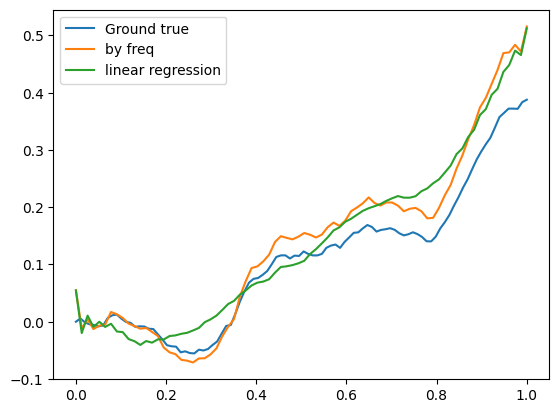

In [18]:
example_sig, example_freq = data[idx]
example_path = data.path[idx]
freq_path = torch.fft.irfft(example_freq)
est_freq = example_sig.type(A.dtype) @ A
est_path = torch.fft.irfft(est_freq)

plt.plot(torch.linspace(0, 1, len(example_path)), example_path, label='Ground true')
plt.plot(torch.linspace(0, 1, len(freq_path)), freq_path, label='by freq')
plt.plot(torch.linspace(0, 1, len(est_path)), est_path, label='linear regression')
plt.legend()

In [19]:
test_data = sig_Dataset(sample_num=10, n=n, hurst=hurst, f_depth=f_depth, s_depth=s_depth)

In [20]:
print('training error: ',
      np.linalg.norm(data.inputs.type(A.dtype) @ A - data.labels)/len(data))
print('test error: ',
      np.linalg.norm(test_data.inputs.type(A.dtype) @ A - test_data.labels)/len(test_data))

training error:  0.10458258949871785
test error:  0.7601868846288202


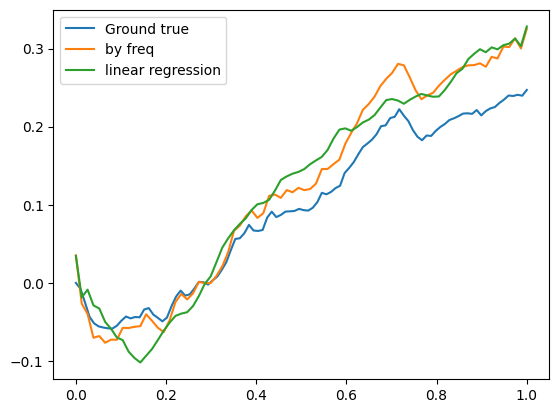

In [21]:
test_sig, test_freq = test_data[idx]
test_path = test_data.path[idx]
test_freq_path = torch.fft.irfft(test_freq)
test_est_freq = test_sig.type(A.dtype) @ A
test_est_path = torch.fft.irfft(test_est_freq)

plt.plot(torch.linspace(0, 1, len(test_path)), test_path, label='Ground true')
plt.plot(torch.linspace(0, 1, len(test_freq_path)), test_freq_path, label='by freq')
plt.plot(torch.linspace(0, 1, len(test_est_path)), test_est_path, label='linear regression')
plt.legend()